<a href="https://colab.research.google.com/github/emilyrshi/PIC16B_Project_Repo/blob/main/Resnet50(ownImages).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Copy of custom-image-classification-with-pytorch**


# Download images from Google

In [35]:
!rm -rf simple_images/
# !rm -rf l/
# !rm -rf o/
# !rm -rf r/
# !rm -rf w/


In [2]:
!pip install simple_image_download

INFO: pip is looking at multiple versions of simple-image-download to determine which version is compatible with other requirements. This could take a while.


In [37]:
from simple_image_download import simple_image_download as simp

def downloadSimpleImages(query, count):
    response = simp.simple_image_download
    response().download(query, count)

# Make this more efficient:
for cls in ['d']:
  downloadSimpleImages(cls, 50)
for cls in ['e']:
  downloadSimpleImages(cls, 50)
for cls in ['h']:
  downloadSimpleImages(cls, 50)
for cls in ['l']:
  downloadSimpleImages(cls, 50)
for cls in ['o']:
  downloadSimpleImages(cls, 50)
for cls in ['r']:
  downloadSimpleImages(cls, 50)
for cls in ['w']:
  downloadSimpleImages(cls, 50)

HTTPSConnectionPool(host='www.gamefaces.com', port=443): Max retries exceeded with url: /wp-content/uploads/2016/11/J-37-8.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))


Delete corrupted images

In [38]:
import os
import glob
from torchvision.io import read_image, ImageReadMode

for ext in ['png', 'jpg']:
    image_paths = glob.glob(os.path.join('simple_images', '*', f'*.{ext}'))
    for path in image_paths:
      try:
        read_image(path, ImageReadMode.RGB)
      except:
        os.remove(path)
        print(f"Deleted {path}")

Deleted simple_images/e/e_24.jpg
Deleted simple_images/e/e_5.jpg
Deleted simple_images/e/e_34.jpg
Deleted simple_images/e/e_18.jpg
Deleted simple_images/e/e_33.jpg
Deleted simple_images/e/e_16.jpg
Deleted simple_images/e/e_6.jpg
Deleted simple_images/e/e_44.jpg
Deleted simple_images/e/e_28.jpg
Deleted simple_images/e/e_46.jpg
Deleted simple_images/e/e_22.jpg
Deleted simple_images/e/e_39.jpg
Deleted simple_images/e/e_25.jpg
Deleted simple_images/e/e_31.jpg
Deleted simple_images/e/e_26.jpg
Deleted simple_images/d/d_40.jpg
Deleted simple_images/d/d_43.jpg
Deleted simple_images/d/d_27.jpg
Deleted simple_images/d/d_39.jpg
Deleted simple_images/d/d_38.jpg
Deleted simple_images/d/d_44.jpg
Deleted simple_images/d/d_41.jpg
Deleted simple_images/d/d_7.jpg
Deleted simple_images/d/d_30.jpg
Deleted simple_images/d/d_26.jpg
Deleted simple_images/d/d_14.jpg
Deleted simple_images/d/d_47.jpg
Deleted simple_images/d/d_50.jpg
Deleted simple_images/d/d_11.jpg
Deleted simple_images/d/d_49.jpg
Deleted simpl

# Imports

In [39]:
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image, ImageReadMode

# Datasets and Dataloaders

In [40]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [41]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.basename(os.path.dirname(path)))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [42]:
dataset = CustomDataset('simple_images/', transform)

In [43]:
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [44]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False),
    "val": DataLoader(val_set, batch_size=8, shuffle=False)
}

# Model Definition

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(2048, 7)
model.to(device)
pass

In [47]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training

In [48]:
EPOCHS = 10
NUM_CLASSES = len(dataset.class_lbl)

In [49]:
dataset.class_lbl

{'d': 0, 'e': 1, 'h': 2, 'l': 3, 'o': 4, 'r': 5, 'w': 6}

In [50]:
metrics = {
    'train': {'loss': [], 'accuracy': []},
    'val': {'loss': [], 'accuracy': []},
}

In [56]:
for epoch in range(20):
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(f'Epoch {epoch}')

  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')
    for images, labels in dataloaders[phase]:
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=7)

        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1

    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)

Epoch 0
-------- train --------
Loss: 2.01943651676178, Accuracy: 0.125

-------- val --------
Loss: 1.9853578209877014, Accuracy: 0.0625

Epoch 1
-------- train --------
Loss: 2.0400446796417238, Accuracy: 0.11

-------- val --------
Loss: 1.9940047562122345, Accuracy: 0.125

Epoch 2
-------- train --------
Loss: 2.0238602590560912, Accuracy: 0.135

-------- val --------
Loss: 1.9794290959835052, Accuracy: 0.09375

Epoch 3
-------- train --------
Loss: 2.0322671270370485, Accuracy: 0.125

-------- val --------
Loss: 1.9927861988544464, Accuracy: 0.125

Epoch 4
-------- train --------
Loss: 2.0277168464660646, Accuracy: 0.09

-------- val --------
Loss: 1.9861990809440613, Accuracy: 0.09375

Epoch 5
-------- train --------
Loss: 2.028858771324158, Accuracy: 0.11600000023841858

-------- val --------
Loss: 1.978645533323288, Accuracy: 0.125

Epoch 6
-------- train --------
Loss: 2.060823669433594, Accuracy: 0.09100000023841857

-------- val --------
Loss: 1.9877461791038513, Accuracy: 0

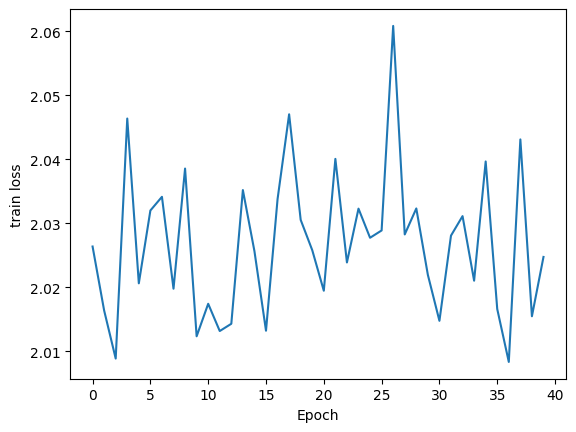

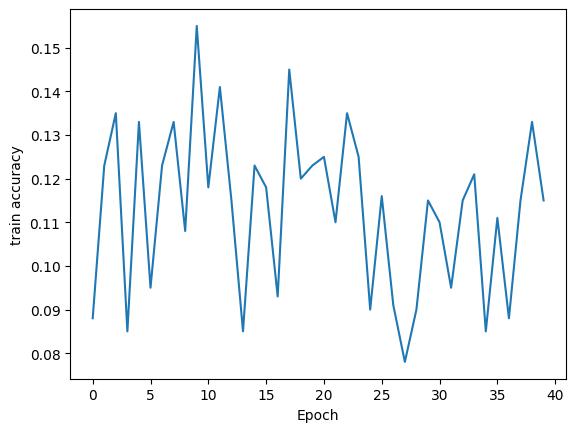

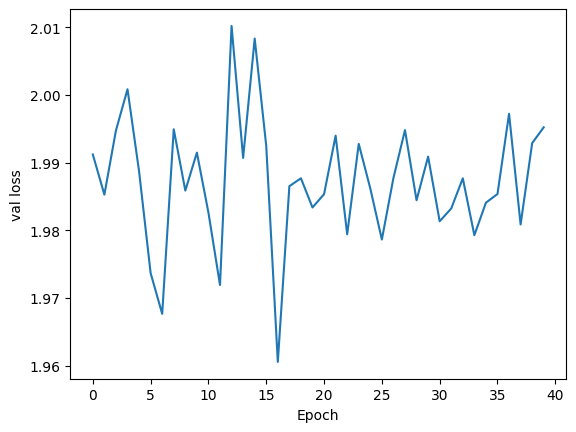

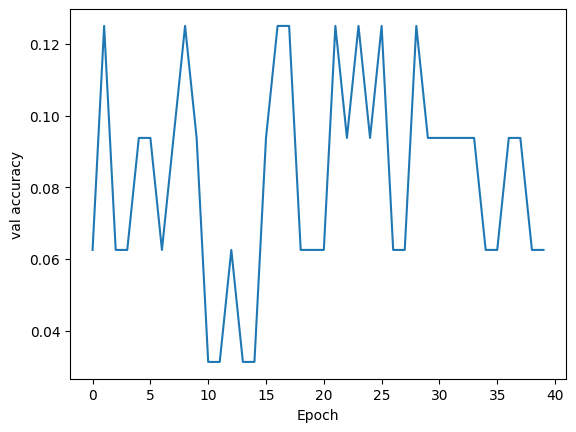

In [57]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

# Testing

In [58]:
preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders['test']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=7)
        out_labels = torch.argmax(output, dim=1)

        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

Test Loss: 1.9742279052734375, Test Accuracy: 0.125


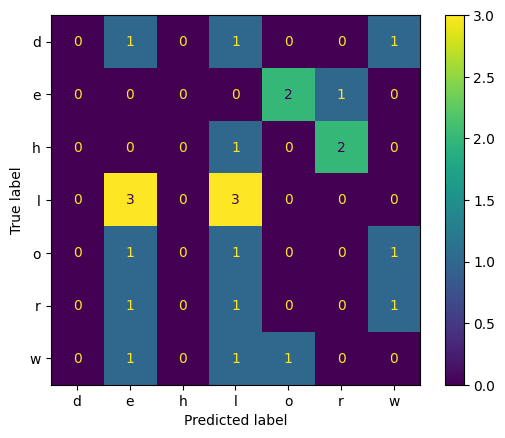

In [59]:
class_labels = sorted(dataset.class_lbl.keys())

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

In [60]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]

<ipython-input-60-01146010730f>:3: RuntimeWarning: invalid value encountered in scalar divide
  stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]


In [61]:
stats

,Precision,Recall
d,NaN,0.0
e,0.000,0.0
h,NaN,0.0
l,0.375,0.5
o,0.000,0.0
r,0.000,0.0
w,0.000,0.0
